<h1><center><font size="6">Cats or Dogs - using CNN with Transfer Learning</font></center></h1>


<center><img src="https://www.theladders.com/wp-content/uploads/dog-cat-190709-1000x563.jpg" width="900"></img></center>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Load packages and set parameters</a>  
- <a href='#3'>Read the data</a>  
- <a href='#4'>Data exploration</a>
    - <a href='#41'>Class distribution</a>
    - <a href='#42'>Images samples</a>
- <a href='#5'>Model</a>  
    - <a href='#51'>Prepare the model</a>  
    - <a href='#52'>Train the model</a>  
    - <a href='#53'>Validation accuracy and loss</a>  
    - <a href='#54'>Validation accuracy per class</a>  
- <a href='#6'>Prepare submission</a>     
- <a href='#7'>Conclusions</a>
- <a href='#8'>References</a>



# <a id="1">Introduction</a>  


## Dataset

The **train** folder contains **25,000** images of **dogs** and **cats**. Each image in this folder has the label as part of the filename. The **test** folder contains **12,500** images, named according to a numeric id.  
For each image in the test set, you should predict a probability that the image is a dog (**1** = **dog**, **0** = **cat**).

### 현재 train data (25000개) // test data (12500개)

## Method

For the solution of this problem we will use a pre-trained model, ResNet-50, replacing only the last layer.

#### ■ 주의 : tensorflow 2.0 이상인 버전에서는 이 코드가 제대로 동작을 안함.

# <a id="2">Load packages</a>

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
%matplotlib inline 

Using TensorFlow backend.


## Parameters

Here we set few parameters used in the model. The image size is **112**.    
The images are stored in two folders, **train** and **test**.  
There are two image classes: **Dog** and **Cat**.  
We will use a subset of the training data set (**20,000** images).  From the training set, **50%** will be used for training, **50%** for validation.  
A pre-trained model from **ResNet-50** will be used.  
A number of **10** epochs will be used for training.  



In [2]:
TEST_SIZE = 0.5
RANDOM_STATE = 2018
BATCH_SIZE = 64
NO_EPOCHS = 20 # 에폭수 (현재 20에폭)
NUM_CLASSES = 2 # 개/고양이 2종류
SAMPLE_SIZE = 20000 # 20000개의 Sample들을 이용

PATH = 'E:\\kaggle\\dogs-vs-cats\\'

TRAIN_FOLDER = 'E:\\kaggle\dogs-vs-cats\\train\\'
TEST_FOLDER =  'E:\\kaggle\dogs-vs-cats\\test\\'

IMG_SIZE = 112
RESNET_WEIGHTS_PATH = 'E:\\kaggle\\dogs-vs-cats\\resnet50\\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
# resnet50의 pre-trained(미리 학습된) 모델의 가중치 값들을 불러옴.

# <a id="3">Read the data</a>

We set the train image list.   
Setting the **SAMPLE_SIZE** value we can reduce/enlarge the size of the training set.    
Currently **SAMPLE_SIZE** is set to **20,000**.


In [3]:
train_image_path = os.path.join(PATH, "train.zip")
test_image_path = os.path.join(PATH, "test.zip")

In [4]:
# 앞축파일을 풀지 않았을 때 사용하는 코드
# 앞축파일을 이미 풀었다면 이 코드는 사용할 필요가 없다.

# import zipfile
# with zipfile.ZipFile(train_image_path,"r") as z:
    # z.extractall(".")

In [5]:
# with zipfile.ZipFile(test_image_path,"r") as z:
    # z.extractall(".")

In [6]:
train_image_list = os.listdir("E:\\kaggle\\dogs-vs-cats\\train\\") # [0:SAMPLE_SIZE] 그냥 전체다 훈련 시킬 꺼임.
test_image_list = os.listdir("E:\\kaggle\\dogs-vs-cats\\test\\")

# 결과 확인
print(train_image_list[0:4])
print(test_image_list[0:4])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg']
['1.jpg', '10.jpg', '100.jpg', '1000.jpg']


We set a function for parsing the image names to extract the first 3 letters from the image names, which gives the label of the image. It will be either a cat or a dog. We are using one hot encoder, storing [1,0] for **cat** and [0,1] for **dog**.

#### onehot encoding 과정이다.
#### 고양이는 [1,0] , 개는 [0,1] 이라고 라벨(labeling)할 것이다.

In [7]:
# label_pet_image_one_hot_encoder(img) 함수이해를 돕기 위한 코드
print('cat.0.jpg'.split('.'))
print('cat.0.jpg'.split('.')[-3])

['cat', '0', 'jpg']
cat


In [8]:
def label_pet_image_one_hot_encoder(img):
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]

We are defining as well a function to process the data (both train and test set). 

#### ■ 이미지 전처리 함수 process_data(data_image_list, DATA_FOLDER, isTrain=True)

In [9]:
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        # cv.resize를 통하여 원하는 이미지 SIZE로 이미지들을 통일 시킴. 
        # 이미지 사이즈 통일로 학습을 원활하게 함
        
        data_df.append([np.array(img),np.array(label)])
        # np.array(img)로 이미지를 numpy형태로 data_df에 저장.
        # np.array(label)로 이미지에 대한 정답을 data_df에 저장.
        
    shuffle(data_df)
    # 학습을 더 잘되게 하기위해 shuffle로 섞는다.
    return data_df

# <a id="4">Data exploration</a>


## <a id="41">Class distribution</a>

Let's inspect the train data to check the **cat**/**dog** distribution.   We show first the split in the reduced train data.

#### train데이터에 개와 고양이 이미지가 몇개씩 존재하는지 확인할 것이다.

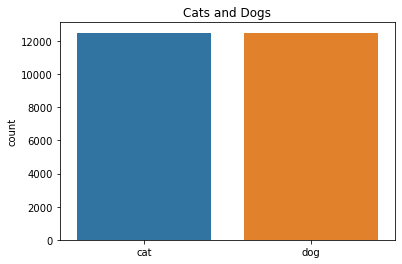

In [10]:
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[-3])
    sns.countplot(labels)
    plt.title('Cats and Dogs')
    
plot_image_list_count(train_image_list)

Let's show also the class distribution in the full train data set.

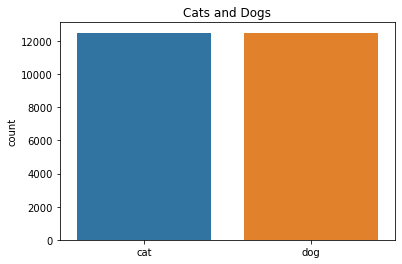

In [11]:
plot_image_list_count(os.listdir(TRAIN_FOLDER))

## <a id="42">Images samples</a>

Let's represet some of the images. We start with a selection from the train set. We will show the first 25 images from the train set.

First,  we process the train data, reading the images and creating a table with images and labels. If the data is trom train set, the label is the one calculated with one hot encoding; if the data is from test set, the label will be the image number.

#### 앞에서 정의하였던 process_data 함수를 통하여 train_data 이미지들을 numpy arrary형태와 Label 형태로 전처리 할것이다.

In [12]:
train = process_data(train_image_list, TRAIN_FOLDER)

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [02:11<00:00, 189.47it/s]


Then, we plot the image selection.

#### show_images 함수를 통하여 25개의 train_data들을 미리 확인해 볼 것이다.

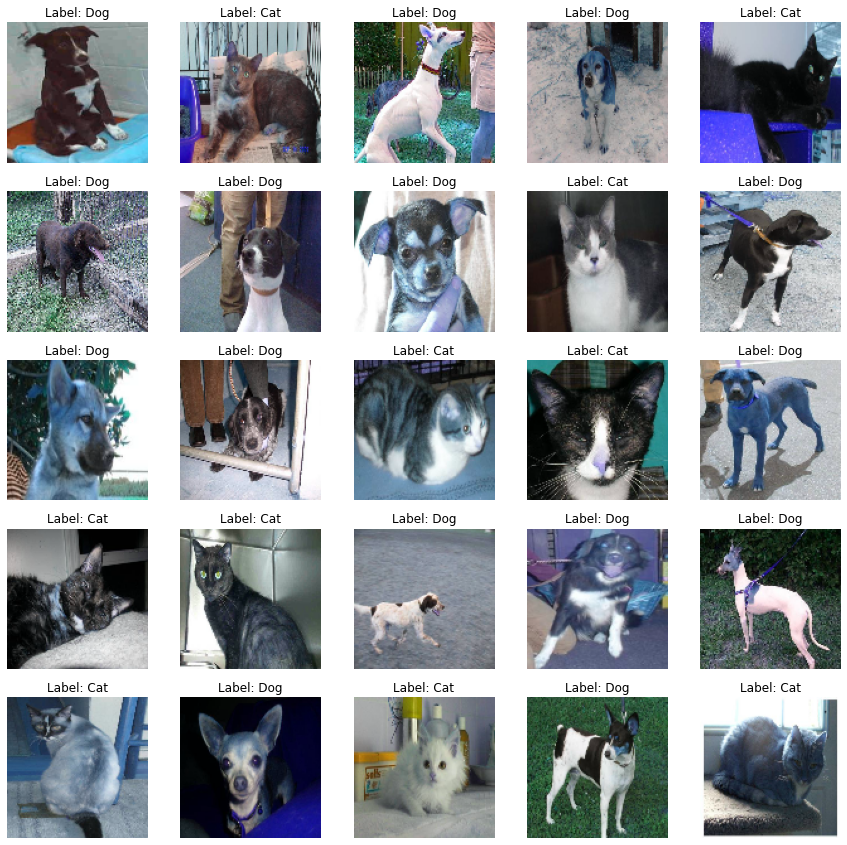

In [13]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(train)

Let's also show a selection of the train set. We prepare the test set.

#### 앞에서 정의하였던 process_data 함수를 통하여 test_data 이미지들을 numpy arrary형태와 Label 형태로 전처리 할것이다.

In [14]:
test = process_data(test_image_list, TEST_FOLDER, False)

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:13<00:00, 169.40it/s]


Then, we show a selection of the test set.

#### show_images 함수를 통하여 25개의 test_data들을 미리 확인해 볼 것이다.

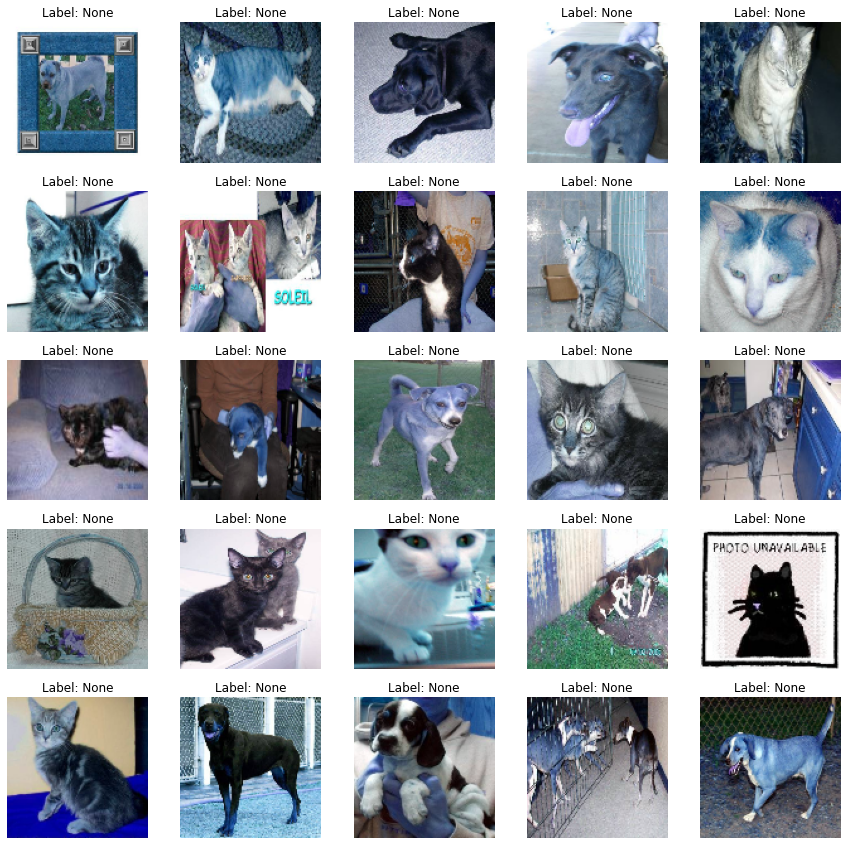

In [15]:
show_images(test,True)

# <a id="5">Model</a>

## <a id="51">Prepare the model</a>

Let's start by preparing the model.

### Prepare the train data

In [16]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
# cnn처리를 하기위해서 train_data들을 4차원 형태로 reshape

y = np.array([i[1] for i in train])

print(X[0].shape)

(112, 112, 3)


### Prepare the model

We initialize the **ResNet-50** model, adding an additional last layer of type **Dense**, with **softmax** activation function.   

We also set the first layer of the model to be not trainable, becaise **ResNet-50** model was already trained.

#### ■ 미리 훈련(pre-trained)된 resnet-50 모델을 사용하되, 마지막 부분만 Dense layer와 softmax layer를 사용할 것이다.

In [17]:
# tensorflow 2.0 이상이면 이게 제대로 작동안한다.

model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights=RESNET_WEIGHTS_PATH))
model.add(Dense(NUM_CLASSES, activation='softmax'))

# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Compile the model

We compile the model, using a **sigmoid** optimized, the loss function as **categorical crossentropy** and the metric **accuracy**.

In [18]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# optimizer(경사하강법) : sgd
# loss(오차함수) : 분류문제라서 crossentropy 함수를 쓸거임
# metrics=['accuracy'] : 정확도를 척도로 삼을거임.

### Model summary

We plot the model description. We can see that the **ResNet-50** model represent the 1st layer of our model, of type **Model**.

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


Let's also show the model graphical representation using **plot_model**.

In [20]:
# plot_model(model, to_file='model.png')
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Split the train data in train and validation

We split the train data in two parts. One will be reserved for train set, the second for validation set. Only the train subset of the data will be used for training the model; the validation set will be used for validation, during training.

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# TEST_SIZE = 0.5 (절반은 train 절반은 test로 사용할거임.)
# RANDOM_STATE = 2018

## <a id="52">Train the model</a>

We are now ready to train our model.

### 학습 시작

In [22]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

# Image_size를 224에서 112로 줄여서 훈련시켰음.(Out of Memory 문제 때문에)
# NO_EPOCHS = 20
# BATCH_SIZE = 64

Train on 12500 samples, validate on 12500 samples
Epoch 1/20
12500/12500 [==============================] - 39s 3ms/sample - loss: 0.8938 - acc: 0.8779 - val_loss: 0.2651 - val_acc: 0.9126
Epoch 2/20
12500/12500 [==============================] - 33s 3ms/sample - loss: 0.0639 - acc: 0.9782 - val_loss: 0.1892 - val_acc: 0.9276
Epoch 3/20
12500/12500 [==============================] - 33s 3ms/sample - loss: 0.0147 - acc: 0.9970 - val_loss: 0.1963 - val_acc: 0.9334
Epoch 4/20
12500/12500 [==============================] - 33s 3ms/sample - loss: 0.0074 - acc: 0.9991 - val_loss: 0.2138 - val_acc: 0.9358
Epoch 5/20
12500/12500 [==============================] - 34s 3ms/sample - loss: 0.0051 - acc: 0.9990 - val_loss: 0.2195 - val_acc: 0.9353
Epoch 6/20
12500/12500 [==============================] - 33s 3ms/sample - loss: 0.0032 - acc: 0.9994 - val_loss: 0.2247 - val_acc: 0.9377
Epoch 7/20
12500/12500 [==============================] - 33s 3ms/sample - loss: 0.0019 - acc: 0.9999 - val_loss: 0.

## <a id="53">Validation accuracy and loss</a>

Let's show the train and validation accuracy on the same plot. As well, we will represent the train and validation loss on the same graph.

### ■ 그래프로 결과 표시하기

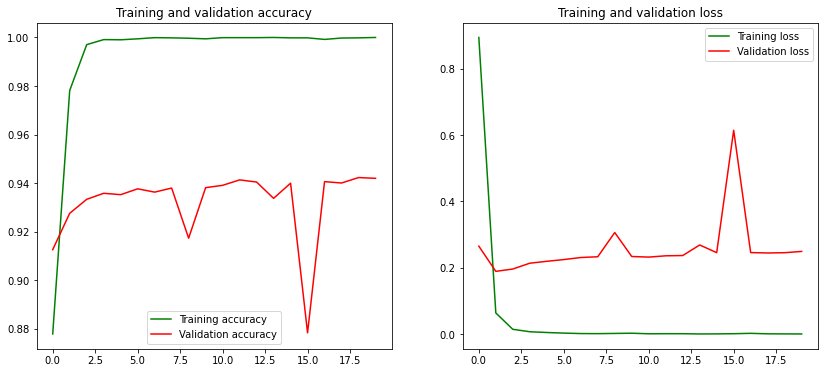

In [23]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
    
plot_accuracy_and_loss(train_model)

Let's also show the numeric validation accuracy and loss.

In [24]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.24927549046318395
Validation accuracy: 0.942


## <a id="54">Validation accuracy per class</a>

Let's show the validation accuracy per each class.

We start by predicting the labels for the validation set.

In [25]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)

#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

We create two indices, **correct** and **incorrect**, for the images in the validation set with class predicted correctly and incorrectly, respectively.

In [26]:
# np.nonzero : 요소들 중에서 0이 아닌 값들의 index들을 반환해 주는 함수

correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]


We saw what is the number of correctly vs. incorrectly predicted values in the validation set.    

We show here the classification report for the validation set, with the accuracy per class and overall.

In [27]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Class 0:       0.93      0.95      0.94      6231
    Class 1:       0.95      0.93      0.94      6269

    accuracy                           0.94     12500
   macro avg       0.94      0.94      0.94     12500
weighted avg       0.94      0.94      0.94     12500



# <a id="6">Prepare the submission</a>

### Show test images with predicted class

Let's show few of the test images with the predicted class. For this, we will have to predict the class.


### ■ Test_data 이미지 25개를 가져와서 예측결과 미리 확인하기 

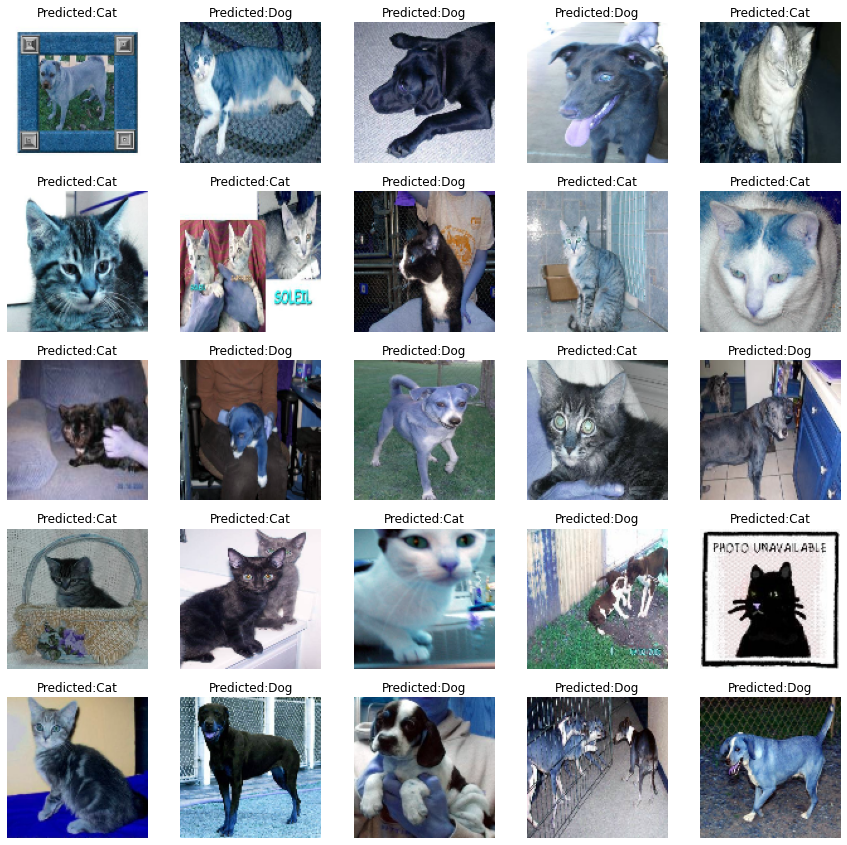

In [28]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

### Test data prediction

In [29]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    # cnn 처리를 위한 4차원 reshape
    predicted = model.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])

100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [03:02<00:00, 68.55it/s]


### Submission file

Let's prepare now the submission file.

In [30]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("E:\kaggle\dogs-vs-cats\submission\\submission.csv", index=False)

# <a id="7">Conclusions</a>

Using a pretrained model for Keras, ResNet-50, with a Dense model with softmax activation added on top and training with a reduced set of  we were able to obtain quite good model in terms of validation accuracy.   
The model was used to predict the classes of the images from the independent test set and results were submitted to test the accuracy of the prediction with fresh data.  


# <a id="8">References</a>

[1] Dogs vs. Cats Redux: Kernels Edition, https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition  
[2] ResNet pretrained models for Keras, https://www.kaggle.com/keras/resnet50  



